# Optimize SageMaker Endpoint Auto scaling using Locust

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install sagemaker
!pip install locust

In [2]:
from sagemaker import Session
import boto3
import time

region = boto3.Session().region_name
sm_client = boto3.client("sagemaker", region_name=region)
sagemaker_session = Session()

role = "arn:aws:iam::138140302683:role/service-role/AmazonSageMaker-ExecutionRole-20230522T162566"

In [3]:
# general model settings

registered_model_name_s3 = "model-mnist"
instance_type = "ml.m6g.large"
hardware = "cpu"
base_model_package_arn = "arn:aws:sagemaker:us-east-1:138140302683:model-package/mnist-model/4"

##### 1. Identify Application characteristics

To determine to the correct scaling property, the first step in the plan is to find application behavior on the chosen hardware. This can be achieved by running the application on a single host and increasing the request load to the endpoint gradually until it saturates.

Run a Locust test until you get 1% failure rate. That amount of RPS is the amount a single instance can handle.

In [5]:
# create an evaluation endpoint

from typing import Tuple
from sagemaker.model import Model

def get_model_data(model_package_arn: str) -> Tuple[str, str]:
    """Get container url and model data url from a model package arn"""
    describe_model_package = sm_client.describe_model_package(
        ModelPackageName=model_package_arn
    )

    container_url = describe_model_package["InferenceSpecification"]["Containers"][0]["Image"]
    model_data_url = describe_model_package["InferenceSpecification"]["Containers"][0]["ModelDataUrl"]

    return container_url, model_data_url

container_url, model_data_url = get_model_data(model_package_arn=base_model_package_arn)

endpoint_name = f"{registered_model_name_s3}-evaluation-endpoint"
model = Model(
    name=f"{registered_model_name_s3}-evaluation-model",
    image_uri=container_url, 
    model_data=model_data_url, 
    role=role
)

predictor = model.deploy(
    initial_instance_count=1, 
    instance_type=instance_type, 
    endpoint_name=endpoint_name
)

endpoint = sm_client.describe_endpoint(EndpointName=endpoint_name)
variant_name = endpoint["ProductionVariants"][0]["VariantName"]

print(f"\nEndpointName: {endpoint_name}, VariantName: {variant_name}")

----!
EndpointName: model-mnist-evaluation-endpoint, VariantName: AllTraffic


In [6]:
# start locust interface

import os
import subprocess

os.environ["REGION"] = "us-east-1"
os.environ["CONTENT_TYPE"] = "application/json"
os.environ["PAYLOAD_FILE"] = "payload/payload.json"

locust_process = subprocess.Popen(["locust", "-f", "locust/locustfile.py", "--host", f"https://{endpoint_name}"])

if os.path.exists(os.environ["PAYLOAD_FILE"]):
    print("Access the Locust UI at: http://localhost:8089\n")
    print("")
else:
    print(f"Payload file not found at: {os.environ['PAYLOAD_FILE']}")

Access the Locust UI at: http://localhost:8089




Now run a locust test that reaches 1% failure rate, or passes a threshold of acceptable latency, then stop, and move on to the next cells.

##### 1.1 Analyzing the result

We then analyze the results using hosting endpoint metrics. Below is a visualization of the invocation metrics, and from that, it follows that the hardware utilization. By layering invocations and utilization graphs, we are able to easily set limits for invocations per instance.

In this step we run various scaling percentage to find the right scaling limit. As a general scaling rule, the utilization percentage should be around 40% if you are optimizing for availability, around 70% if you are optimizing for cost, and around 50% if you want to balance availability and cost. The above guidance gives an overview of the two dimensions, availability and cost. The lower the threshold, the better the availability, and the higher the threshold, the better the cost.

Maximum Invocation seen in benchmarking = 9456.0
Invocation upper limit=6619 for 70.0%,             lower limit=4256 for 45.0%


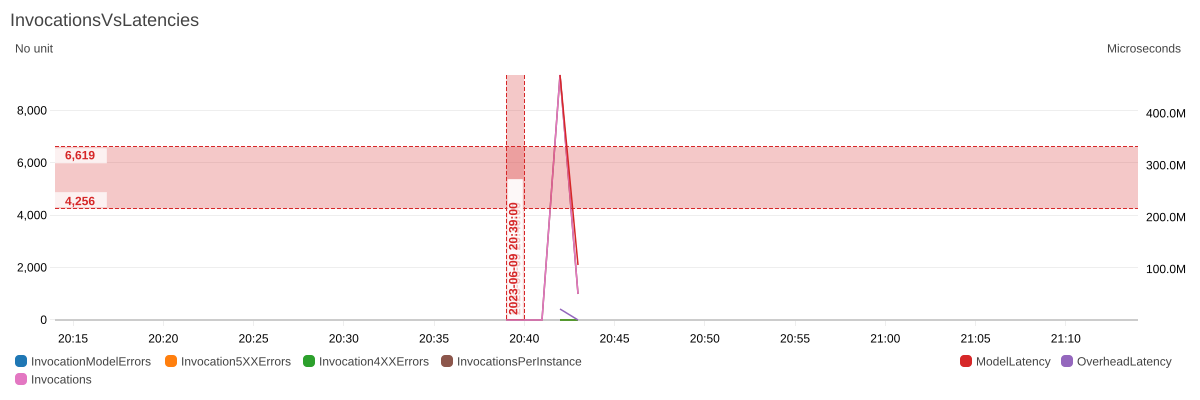

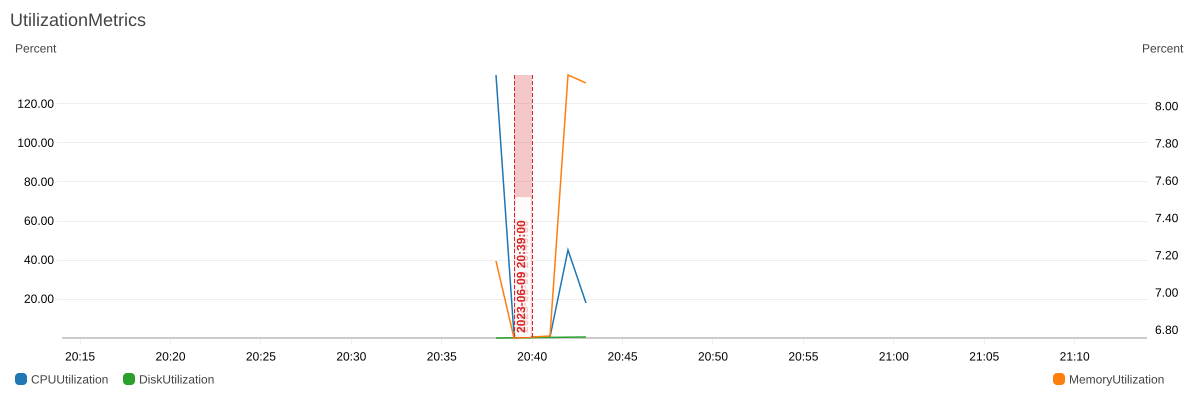

In [14]:
import datetime
from helpers.analysis import analysis_and_visualize_time_now

# The following function allows you to change the percentage and see how the invocations,
# latency and utilization metrics limit. we highly recommended that you play around with
# different percentage thresholds and find the best fit based on your metrics.
# For this use-case, we have decided to proceed with a threshold between 45 - 70%

max_value, upper_limit, lower_limit = analysis_and_visualize_time_now(
    endpoint_name=endpoint_name,
    variant_name=variant_name,
    upper_threshold = 70.0, # change this
    lower_threshold = 45.0, # change this
    hardware = hardware,
    timedelta_minutes = 30,
    hours_timezone = 6,
)

##### 2. Set Scaling expectation:

The next step in the plan is to set the scaling expectation and develop scaling policies based on that expectation. This step involves defining the maximum and minimum requests to be served. The `max_rps` and `min_rps` is a personal prediction of the usage that the endpoint will face, there's no way to calculate it unless putting it into prod and checking how many requests.


In [16]:
import math

max_rps = 300
min_rps = 1

# Based on the above set expectation, we define the MinCapacity and MaxCapacity using the formula below.
# As InvocationsPerInstance is per minute, we normalize it second for the below calculation.
rps_single_instance = upper_limit / 60

# The growth factor is the amount of additional capacity that you are willing to add when your scale exceeds max_rps
growth_factor = 1.2

max_capacity = math.ceil((max_rps / rps_single_instance) * growth_factor)
min_capacity = math.ceil((min_rps / rps_single_instance))

invocations_per_instance = upper_limit
min_capacity = min_capacity if min_capacity > 0 else 1 

print(f"Scaling configuration: MaxCapacity = {max_capacity}, MinCapacity = {min_capacity}, InvocationsPerInstance = {invocations_per_instance}")

Scaling configuration: MaxCapacity = 4, MinCapacity = 1, InvocationsPerInstance = 6619


##### 2a. Apply scaling policies to SageMaker endpoint

In order to define the scaling policies, you should register scaling and then add policies. The following section defines functions for registering scaling, setting target tracking policies on CPU / GPU utilization and InvocationsPerInstance.

In [18]:
from helpers.endpoint_scaling import register_scaling
from helpers.endpoint_scaling import set_target_scaling_on_invocation
from helpers.endpoint_scaling import set_target_scaling_on_hardware_utilization
from helpers.endpoint_scaling import clear_auto_scaling_and_reset_to_initial_count
from helpers.endpoint_scaling import wait_for_endpoint_to_finish_updating_or_creating


wait_for_endpoint_to_finish_updating_or_creating(
    endpoint_name=endpoint_name
)

# try to de register scaling if any is already present
try:
    clear_auto_scaling_and_reset_to_initial_count(
        endpoint_name=endpoint_name,
        variant_name=variant_name,
        initial_count=1
    )
except:
    print("No scaling to de-register")

# register scaling
register_scaling_response = register_scaling(
    endpoint_name=endpoint_name,
    variant_name=variant_name,
    max_capacity=max_capacity,
    min_capacity=min_capacity,
)

invocation_scaling = set_target_scaling_on_invocation(
    endpoint_name=endpoint_name, 
    variant_name=variant_name, 
    target_value=invocations_per_instance,
    scale_out_cool_down=10,
    scale_in_cool_down=100,
)

# setting target value of 100% means that we're saying that each CPU of the EC2 instance
# should be at 50%. This is because ml.m6g.large has 2 vCPU, and 50*2 = 100%.
# if we wanted to keep the target value at 30%, we would have put 30 * 2 = 60%.
cpu_scaling = set_target_scaling_on_hardware_utilization(
    endpoint_name=endpoint_name, 
    variant_name=variant_name, 
    hardware="cpu", 
    target_value=100
)

print("Done")

Endpoint model-mnist-evaluation-endpoint is in InService state
Endpoint model-mnist-evaluation-endpoint is in updating/creating
Endpoint model-mnist-evaluation-endpoint is in updating/creating
Endpoint model-mnist-evaluation-endpoint is in updating/creating
Endpoint model-mnist-evaluation-endpoint is in InService state
Done


Now try the same test again, and see how it performs with the autoscaling. Run the cell below to see the autoscaling in action.

Also check the alarms in Cloudwatch to see how they get triggered, and if `invocations_per_instance` needs to be adjusted.

In [ ]:
import logging
import time
from IPython.display import clear_output

from helpers.analysis import get_current_invocation_per_instance
from helpers.analysis import get_autoscaling_last_activity

logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)

while True:    
    response = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = response["EndpointStatus"]
    instance_count = response["ProductionVariants"][0]["CurrentInstanceCount"]

    current_invocation_per_instance = get_current_invocation_per_instance(
        endpoint_name=endpoint_name,
        variant_name=variant_name
    )
    start_time, end_time, description, cause = get_autoscaling_last_activity(
        endpoint_name=endpoint_name,
        variant_name=variant_name,
    )

    logging.info(f"Status: {status}")
    logging.info(f"Current Instance count: {instance_count}")
    logging.info(f"Current invocation per instance amount: {current_invocation_per_instance} vs limit: {invocations_per_instance}")
    
    logging.info("Autoscaling last activity:")
    logging.info(f"\t- Start time: {start_time}")
    logging.info(f"\t- End time: {end_time}")
    logging.info(f"\t- Description: {description}")
    logging.info(f"\t- Cause: {cause}")

    logging.info("-----")

    time.sleep(3)
    clear_output(wait=True)

##### 2b. Evaluate the scaling policy

Evaluate the scaling policy using the code below, as well as checking the metrics in cloudwatch, and the alarms.

Maximum Invocation seen in benchmarking = 38976.0
Invocation upper limit=0 for 0%,             lower limit=0 for 0%


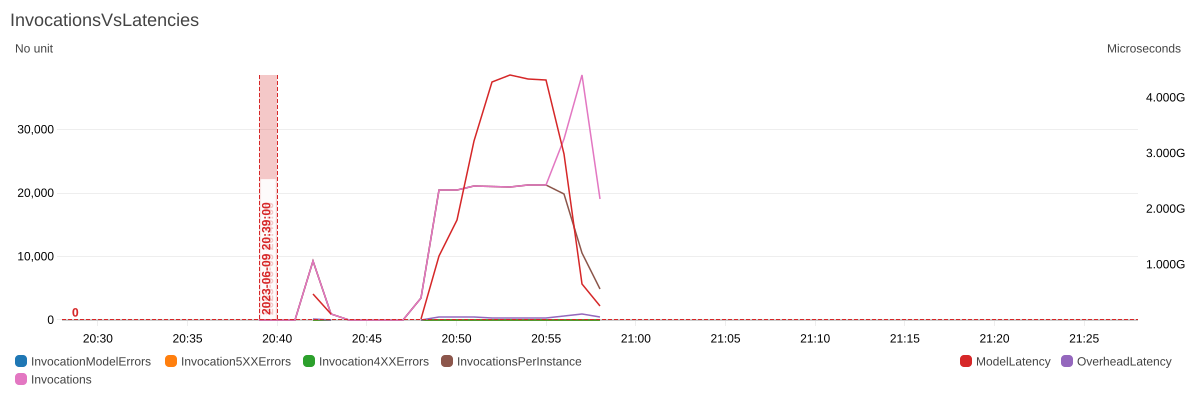

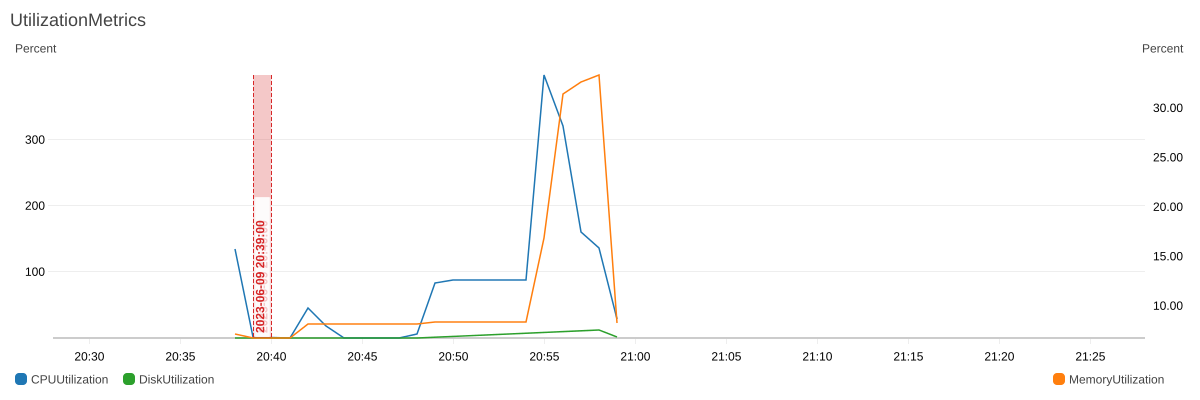

(38976.0, 0, 0)

In [22]:
analysis_and_visualize_time_now(
    endpoint_name=endpoint_name,
    variant_name=variant_name,
    upper_threshold = 0,
    lower_threshold = 0,
    hardware = hardware,
    timedelta_minutes = 30,
    hours_timezone = 6,
)

In [ ]:
from helpers.endpoint_scaling import clear_auto_scaling_and_reset_to_initial_count

wait_for_endpoint_to_finish_updating_or_creating(
    endpoint_name=endpoint_name
)

clear_auto_scaling_and_reset_to_initial_count(
    endpoint_name=endpoint_name,
    variant_name=variant_name,
    initial_count=1
)

##### 3. Step scaling policy

To have more control we can use Step Scaling policy. It defines boundaries that adds or remove instances based on them. It DOESN'T create any alarm, unlike TargetTrackingScaling, so because of this we have to create our own alarms for scale out and scale in. The advantage, is that this is much more configurable, i.e. in terms of activation time which can be calculated with:

```
    evaluation_period * period
```

This means that if period is `60s` and evaluation_period is `1`, it will take 60s to activate.

The step scaling policy threshold aren't defined in percentage, but rather on the target metric unit. This means that if the cloudwatch alarm is tracking InvocationPerInstance, the steps boundaries are in InvocationPerInstance, and not in percentage with respect to it as I originally thought.

---

For example, if we have `threshold = 1000` of InvocationPerInstance, the following ScaleOut policy adds:

  - One instance if InvocationPerInstance is between 1000 and 1100
  - Three instances if InvocationPerInstance is between 1100 and 1800
  - Four instances if InvocationPerInstance is greater than 1800

  ```python
  step_scaling_policy_configuration = {
      "AdjustmentType": "ChangeInCapacity",
      "StepAdjustments": [
          {
              "MetricIntervalLowerBound": 0.0,
              "MetricIntervalUpperBound": 100.0,
              "ScalingAdjustment": 1,
          },
          {
              "MetricIntervalLowerBound": 100.0,
              "MetricIntervalUpperBound": 800.0,
              "ScalingAdjustment": 3,
          },
          {
              "MetricIntervalLowerBound": 800.0,
              "ScalingAdjustment": 4
          },
      ],
      "MetricAggregationType": "Average",
  }
  ```

---

With `threshold = 1000` of InvocationPerInstance, and comparison operator set to `LessThanOrEqualToThreshold`, if we have for example 0 requests, we get a value of `-1000` in the alarm for it. Therefore with the following policy we remove:

  - One instance if InvocationPerInstance is between -500 and -1000
  - Two instances if InvocationPerInstance is < -500

  ```python
  step_scaling_policy_configuration = {
      "AdjustmentType": "ChangeInCapacity",
      "StepAdjustments": [
          {
              "MetricIntervalUpperBound": -500.0,
              "ScalingAdjustment": -2,
          },
          {
              "MetricIntervalLowerBound": -500.0,
              "MetricIntervalUpperBound": 0.0,
              "ScalingAdjustment": -1,
          },
      ],
      "MetricAggregationType": "Average",
  }
  ```

  ```
  -1000          0
  |______________|
        -500
  :....:    :....:
  -2        -1
  ```

In [13]:
from helpers.endpoint_scaling import register_scaling
from helpers.endpoint_scaling import create_step_scaling_policy
from helpers.endpoint_scaling import create_alarm_based_on_step_policy
from helpers.endpoint_scaling import wait_for_endpoint_to_finish_updating_or_creating
from helpers.endpoint_scaling import clear_auto_scaling_and_reset_to_initial_count

wait_for_endpoint_to_finish_updating_or_creating(
    endpoint_name=endpoint_name
)

# try to de register scaling if any is already present
try:
    clear_auto_scaling_and_reset_to_initial_count(
        endpoint_name=endpoint_name,
        variant_name=variant_name,
        initial_count=1
    )
except:
    print("No scaling to de-register")

register_scaling_response = register_scaling(
    endpoint_name=endpoint_name,
    variant_name=variant_name,
    max_capacity=3,
    min_capacity=1,
)

In [45]:
# scale out step scaling policy

threshold = 1500

step_scaling_policy_configuration = {
    "AdjustmentType": "ChangeInCapacity",
    "StepAdjustments": [
        {
            "MetricIntervalLowerBound": threshold * 0.0, 
            "MetricIntervalUpperBound": threshold * 10.0, # turn numeric value into percentage
            "ScalingAdjustment": 1,
        },
        {
            "MetricIntervalLowerBound": threshold * 10.0,
            "MetricIntervalUpperBound": threshold * 80.0,
            "ScalingAdjustment": 3,
        },
        {
            "MetricIntervalLowerBound": threshold * 80.0, 
            "ScalingAdjustment": 4
        },
    ],
    "MetricAggregationType": "Average",
}

# create step scaling policy
policy_name_scale_out = "step-scaling-out-230612"

step_policy_arn = create_step_scaling_policy(
    endpoint_name=endpoint_name,
    variant_name=variant_name,
    policy_name=policy_name_scale_out,
    step_scaling_policy_configuration=step_scaling_policy_configuration
)

# create cloudwatch alarm
alarm_name_scale_out = f"StepScaling-endpoint/{endpoint_name}-endpoint/variant/{variant_name}-ScaleOut"

create_alarm_based_on_step_policy(
    step_policy_arn=step_policy_arn,
    endpoint_name=endpoint_name,
    variant_name=variant_name,
    alarm_name=alarm_name_scale_out,
    threshold=threshold
)

{'ResponseMetadata': {'RequestId': '2093cce3-8d6a-4f9e-8020-f0f71d9c774a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2093cce3-8d6a-4f9e-8020-f0f71d9c774a',
   'content-type': 'text/xml',
   'content-length': '214',
   'date': 'Mon, 12 Jun 2023 15:58:12 GMT'},
  'RetryAttempts': 0}}

In [55]:
# scale in step scaling policy
threshold = 1000

step_scaling_policy_configuration = {
    "AdjustmentType": "ChangeInCapacity",
    "StepAdjustments": [
        {
            "MetricIntervalUpperBound": -500.0,
            "ScalingAdjustment": -2,
        },
        {
            "MetricIntervalLowerBound": -500.0,
            "MetricIntervalUpperBound": 0.0,
            "ScalingAdjustment": -1,
        },
    ],
    "MetricAggregationType": "Average",
}

# create step scaling policy
policy_name_scale_in = "step-scaling-in-230612"

step_policy_arn = create_step_scaling_policy(
    endpoint_name=endpoint_name,
    variant_name=variant_name,
    policy_name=policy_name_scale_in,
    step_scaling_policy_configuration=step_scaling_policy_configuration
)

# create cloudwatch alarm
alarm_name_scale_in = f"StepScaling-endpoint/{endpoint_name}-endpoint/variant/{variant_name}-ScaleIn"

create_alarm_based_on_step_policy(
    step_policy_arn=step_policy_arn,
    endpoint_name=endpoint_name,
    variant_name=variant_name,
    alarm_name=alarm_name_scale_in,
    threshold=threshold,
    comparison_operator="LessThanOrEqualToThreshold"
)

{'ResponseMetadata': {'RequestId': 'cda03202-def2-43a4-b00c-bf7f19ab5518',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'cda03202-def2-43a4-b00c-bf7f19ab5518',
   'content-type': 'text/xml',
   'content-length': '214',
   'date': 'Mon, 12 Jun 2023 16:29:13 GMT'},
  'RetryAttempts': 0}}

Maximum Invocation seen in benchmarking = 20848.0
Invocation upper limit=0 for 0%,             lower limit=0 for 0%


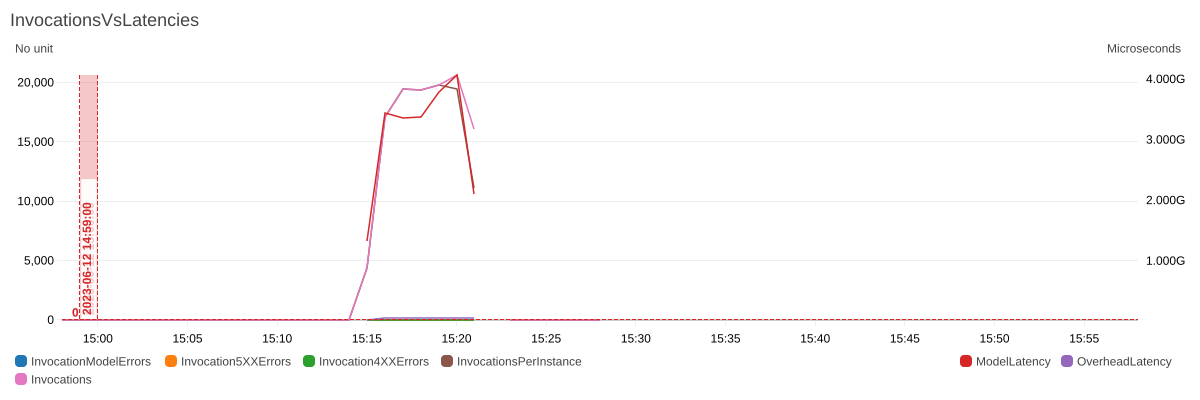

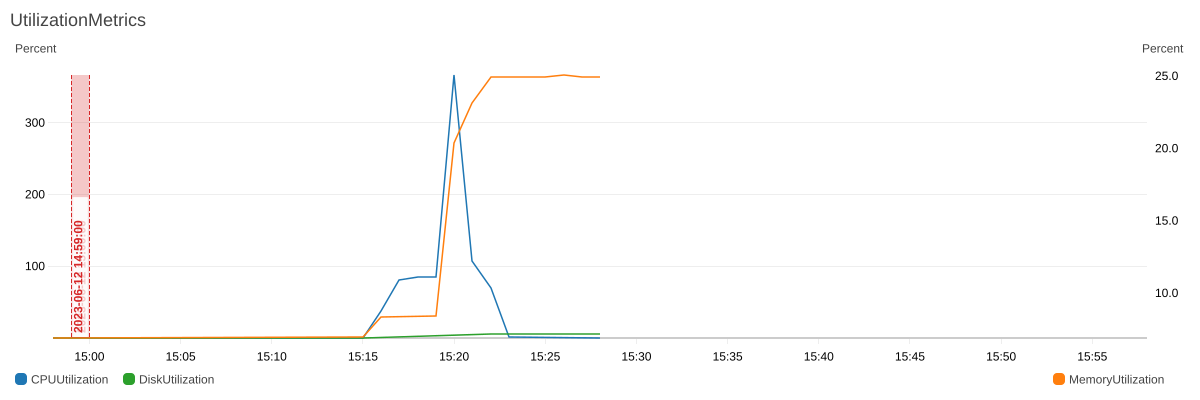

(20848.0, 0, 0)

In [27]:
from helpers.analysis import analysis_and_visualize_time_now

analysis_and_visualize_time_now(
    endpoint_name=endpoint_name,
    variant_name=variant_name,
    upper_threshold = 0,
    lower_threshold = 0,
    hardware = hardware,
    timedelta_minutes = 30,
    hours_timezone = 6,
)

##### 4. Conclusion

In [ ]:
# clean up resources
from helpers.endpoint_scaling import remove_step_scaling_policy

# remove step scaling policy and alarm
try:
    remove_step_scaling_policy(
        alarm_name=alarm_name_scale_out,
        policy_name=policy_name_scale_out
    )

    print("Removed scale out step policy")
except Exception:
    print("No scale out step policy to be removed")

try:
    remove_step_scaling_policy(
        alarm_name=alarm_name_scale_in,
        policy_name=policy_name_scale_in
    )

    print("Removed scale in step policy")
except Exception:
    print("No scale in step policy to be removed")

# delete endpoint configuration
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_name)  
print("Deleted endpoint configuration")

# delete model
sm_client.delete_model(ModelName=model.name)
print("Deleted model")

# delete endpoint
sm_client.delete_endpoint(EndpointName=endpoint_name)
print("Deleted endpoint")

# kill locust
locust_process.kill()
print("Killed locust process")